<a href="https://colab.research.google.com/github/ramon-m-machado/Markdown-Tutorial/blob/master/VGGsNew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of microorganisms into 10 classes using **VGG16** and **VGG19**


# Environment Setup

## Drive


In [1]:
# # get the images from the Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

## Imports

In [2]:
# basic imports
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
# plot imports
import matplotlib.pyplot as plt
import seaborn as sn
import plotly.graph_objects as go

In [4]:
# read and process images
import imageio.v2 as iio
from PIL import Image
import cv2 as cv

In [5]:
# access files in colab's folders
import os

In [6]:
# regex to get the class name from the file name
import re

In [7]:
# some randomness functions
import random

In [8]:
# k-fold (cross validation)
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
# like top_k_categorical_accuracy but for labels integer-encoded
from tensorflow.keras.metrics import sparse_top_k_categorical_accuracy
from sklearn.metrics import f1_score

In [9]:
# imports data augmentation
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img

In [10]:
# confusion matrix
from plotly.subplots import make_subplots
from matplotlib.colors import LinearSegmentedColormap

In [11]:
# imports from evaluation metrics
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import accuracy_score

## GPU

In [12]:
# checking the use of colab's GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Control constants

Path info

In [13]:
# define values related to Colab's environment path
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/FAPESP/images/'
# BASE_PATH = '/content/drive/MyDrive/micro_data/'
FOLDERS = ['Control', 'Serial', 'Streak']  # images will be read from these 3 folders in the base path

Learning info

In [14]:
# define values related to learning, such as image size and number of classes
SIZE = 224  # (size, size)
BORDER = 150  # this will be cutted from the original image, because the microorganism are in the center
INPUT_SHAPE = (224, 224, 3)

NUM_SPLITS = 5  # k value for k-fold cross-validation

NUMBER_OF_CLASSES = 10

BATCH_SIZE_TRAIN = 40
BATCH_SIZE_TEST = 40

CLASSES = ["C1","C2","C3","C4","C5","C6","C7","C8","C9","C10"]

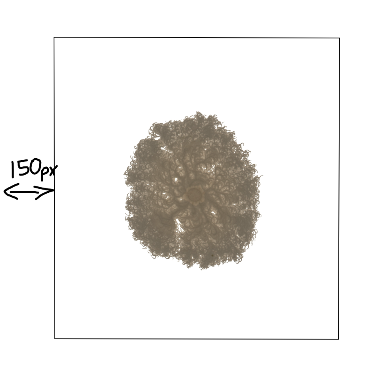

Randomness info

In [15]:
# define a random seed, allowing determinism at experiments
RANDOM_SEED = 42

tf.keras.utils.set_random_seed(RANDOM_SEED)
# tf.config.experimental.enable_op_determinism()

# Loading and preprocessing images

## Read images and construct Dataset

Defining functions to read and preprocess images

In [16]:
def preprocessImg(path, size, border):
  # read the images in folder
  img = np.array(Image.open(path)) #.convert('L')) # uncoment to gray scale images

  # standardizating values (interval [0, 1])
  imgStandard = img / 255

  # cut the border of the image
  imgCutted = imgStandard[border:-border,border:-border]

  # resize the original image
  imgResized = cv.resize(imgCutted, dsize = (size, size))

  return imgResized

In [17]:
def getClassWithRegex(file):
  regex_result = re.search(r"\d-\d*_.M_P1C(\d+)", file)
  imgClass = int(regex_result.groups()[0])-1

  y = np.zeros(NUMBER_OF_CLASSES)
  y[imgClass] = 1

  return y

In [18]:
def readDataImagesFromDrive(files, size, border):
  for file in files:
    img = preprocessImg(file, size, border)
    _, filename = os.path.split(file)
    imgClass = getClassWithRegex(filename)

    yield img, imgClass

  """
  Returns a tf.data.Dataset based on specified params

  - Params

  -- Files: iterable of strings

  List containing the full path of the images

  -- size: integer

  Images loaded will be resized to (size, size)

  -- border: integer

  Number of pixels cropped off from each side of the images. The cropp is made at the original image size.

  -- num_classes: integer

  Number of classes on the image dataset

  -- batch_size: integer

  Number of images at each batch

  -- split: integer or float

  Determines the split method for the dataset.
  integer -> number of splits k for k-fold cross-validation
  float -> split ratio for holdout-validation. The specified value is the % of data in the train dataset.

  - Return

  -- dataset: tf.data.Dataset

  Returns a tf.data.Dataset based on specified params.
  k-fold cross-validation -> a list of tuples of datasets (train, test)
  holdout-validation -> a tuple of datasets (train, test)
  """

In [19]:
def dataset_factory(files, classes, size=400, border=0, num_classes=5, batch_size=32, split=1):

    def create_dataset(file_list):
        return tf.data.Dataset.from_generator(
            lambda: readDataImagesFromDrive(file_list, size, border),
            output_signature=(
                tf.TensorSpec(shape=(size, size, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(num_classes,), dtype=tf.int8)
            )
        ).batch(batch_size)

    skf = StratifiedKFold(n_splits=split, shuffle=True, random_state=RANDOM_SEED)

    folds = []
    for train_index, test_index in skf.split(files, classes):
        train_files = [files[i] for i in train_index]
        test_files = [files[i] for i in test_index]

        train_dataset = create_dataset(train_files)
        test_dataset = create_dataset(test_files)

        folds.append((train_dataset, test_dataset))

    return folds, skf.split(files, classes)

In [20]:
# getting images name and location
files = []
classes = []
for i in range(len(FOLDERS)):
  curr_folder = os.path.join(BASE_PATH, FOLDERS[i])
  for file in os.listdir(curr_folder):
    curr_file = os.path.join(curr_folder, file)
    files.append(curr_file)
    classes.append(list(getClassWithRegex(file)))
classes = np.argmax(np.array(classes, dtype=np.uint8), axis=1)

In [21]:
print(files[0],classes[0])

/content/drive/MyDrive/Colab Notebooks/FAPESP/images/Control/7-11_PM_P1C1_Control.jpg 0


In [22]:
def build_fold_and_indexes():
  # constructing the image dataset
  folds, split_indexes = dataset_factory(
    files,
    classes,
    size = SIZE,
    border = BORDER,
    num_classes = NUMBER_OF_CLASSES,
    batch_size = BATCH_SIZE_TRAIN,
    split = NUM_SPLITS
  )
  return folds, split_indexes

In [23]:
print(files[:5])
print(classes[:5])

['/content/drive/MyDrive/Colab Notebooks/FAPESP/images/Control/7-11_PM_P1C1_Control.jpg', '/content/drive/MyDrive/Colab Notebooks/FAPESP/images/Control/7-11_PM_P1C4_Control.jpg', '/content/drive/MyDrive/Colab Notebooks/FAPESP/images/Control/7-9_PM_P1C4_Control.jpg', '/content/drive/MyDrive/Colab Notebooks/FAPESP/images/Control/7-9_PM_P1C9_Control.jpg', '/content/drive/MyDrive/Colab Notebooks/FAPESP/images/Control/7-10_PM_P1C6_Control.jpg']
[0 3 3 8 5]


Images examples

In [25]:
# creating a data iterator to access the actual data
folds, split_indexes = build_fold_and_indexes()
train_dataset, test_dataset = folds[0]
iterator = train_dataset.as_numpy_iterator()

In [26]:
# getting the first batch of data
batch = iterator.next()
images = batch[0]
labels = batch[1]

/content/drive/MyDrive/Colab Notebooks/FAPESP/images/Control/7-11_PM_P1C1_Control.jpg
[0 0 0 1 0 0 0 0 0 0]


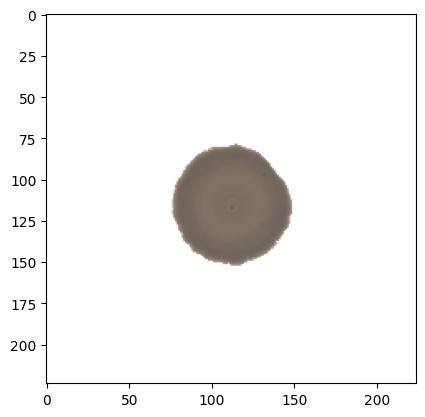

In [27]:
print(files[0])
print(labels[0])
plt.imshow(images[0])

/content/drive/MyDrive/Colab Notebooks/FAPESP/images/Control/7-11_PM_P1C7_Control.jpg
[0 0 0 0 0 0 0 1 0 0]


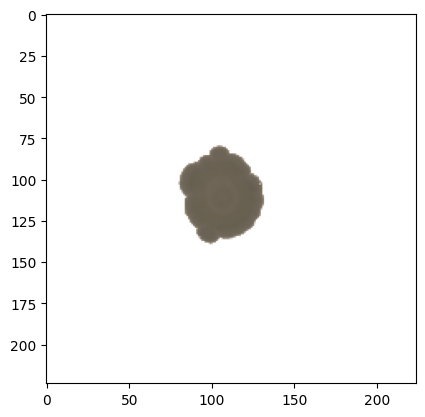

In [28]:
print(files[15])
print(labels[15])
plt.imshow(images[15])

# Training

## VGGs

In [29]:
from keras.models import Model
from keras import optimizers
from keras.layers import Dense, Flatten
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19

In [30]:
def initialize_VGG(is_vgg19=False):

    input_shape = (224, 224, 3)

    base_model = VGG19 if is_vgg19 else VGG16

    vgg = base_model(input_shape=input_shape, weights='imagenet', include_top=False)

    # Freezing blocks from 1 to 5
    for layer in vgg.layers:
        layer.trainable = False

    flatten = Flatten()(vgg.output)

    dense1 = Dense(256, activation='relu')(flatten)
    prediction = Dense(NUMBER_OF_CLASSES, activation='sigmoid')(dense1)

    model = Model(inputs=vgg.input, outputs=prediction)

    return model

**VGG16**

In [31]:
test_vgg = initialize_VGG(is_vgg19 = False)
test_vgg.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

**VGG19**

In [32]:
test_vgg = initialize_VGG(is_vgg19 = True)
test_vgg.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

## Metrics

top 2, 3 and 5k

Example with top 3k:

if the correct class is among the 3 most likely predictions, it counts as a hit towards the top3k

In [33]:
def top_2k_accuracy(y_true,y_pred):
  return sparse_top_k_categorical_accuracy(y_true, y_pred, k=2)

def top_3k_accuracy(y_true,y_pred):
  return sparse_top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_5k_accuracy(y_true,y_pred):
  return sparse_top_k_categorical_accuracy(y_true, y_pred, k=5)

def true_positive(y_true, y_pred):
  return tf.reduce_sum(tf.cast(tf.math.equal(y_true, y_pred), dtype=tf.float32), axis=0)


In [34]:
evaluation_metrics = ['accuracy',
           tf.keras.metrics.TopKCategoricalAccuracy(k=2, name="top_2k", dtype=None),
           tf.keras.metrics.TopKCategoricalAccuracy(k=3, name="top_3k", dtype=None),
           tf.keras.metrics.TopKCategoricalAccuracy(k=5, name="top_5k", dtype=None)]

## Callbacks

Callbacks to save model weights for each fold

In [35]:
cp_filename = lambda vgg, k : f'cp_vgg{vgg}_fold{k}.ckpt'

In [36]:
# Create a callback that saves the model's weights
create_checkpoint_callbacks = lambda num_checkpoints, checkpoint_path, vgg: [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path + cp_filename(vgg, k),
        save_weights_only=True,
        verbose=1
    ) for k in range(1, num_checkpoints+1)
]

In [37]:
CHECKPOINT_PATH_VGG16 = "/content/drive/MyDrive/Colab Notebooks/FAPESP/models/vgg16/"
CHECKPOINT_PATH_VGG19 = "/content/drive/MyDrive/Colab Notebooks/FAPESP/models/vgg19/"
CHECKPOINT_DIR_VGG16 = os.path.dirname(CHECKPOINT_PATH_VGG16)
CHECKPOINT_DIR_VGG19 = os.path.dirname(CHECKPOINT_PATH_VGG19)
NUM_CHECKPOINTS = 5

In [38]:
cp_callback_vgg16 = create_checkpoint_callbacks(NUM_CHECKPOINTS, CHECKPOINT_PATH_VGG16, 16)
cp_callback_vgg19 = create_checkpoint_callbacks(NUM_CHECKPOINTS, CHECKPOINT_PATH_VGG19, 19)

Callback for early stop when loss stop decreasing

In [39]:
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

## K fold Cross-validation

In [50]:
def train_fine_tuning_VGG(train_dataset, test_dataset, cp_callback, evaluation_metrics, epochs, is_vgg19=False):

    vgg = initialize_VGG(is_vgg19)

    # Compile using LR = 2 × 10−5
    vgg.compile(loss='categorical_crossentropy',
                optimizer=optimizers.RMSprop(learning_rate=2e-5),
                metrics=evaluation_metrics)

    # Training
    vgg.fit(
        train_dataset,
        epochs = epochs,
        callbacks=[earlyStopping, cp_callback],
        verbose = False
    )

    # Unfreezing from 4 to 6
    for i in range(11, len(vgg.layers)):
        vgg.layers[i].trainable = True

    # Compile again using LR = 1 × 10−5
    vgg.compile(loss='categorical_crossentropy',
                optimizer=optimizers.RMSprop(learning_rate=1e-5),
                metrics=evaluation_metrics)

    # Training again
    vgg.fit(
        train_dataset,
        epochs = epochs,
        callbacks=[earlyStopping, cp_callback],
        verbose = True
    )

    y_pred = vgg.predict(test_dataset)

    return vgg, y_pred

Training and evaluating **VGG16**

In [51]:
EPOCHS = 100

# Save the predictions of every split
y_pred = []
y_true = []

# Create dictionaries to store metrics for each split
metrics = {
    'loss': np.empty(shape=(NUM_SPLITS)),
    'accuracy': np.empty(shape=(NUM_SPLITS)),
    'top_2': np.empty(shape=(NUM_SPLITS)),
    'top_3': np.empty(shape=(NUM_SPLITS)),
    'top_5': np.empty(shape=(NUM_SPLITS))
}

k = 0
for count, (train_dataset, test_dataset) in enumerate(folds):
    print(f'\nk: {k+1}/{NUM_SPLITS}\n')

    # Train the neural network and get predictions using VGG16
    vgg, y_pred_fold = train_fine_tuning_VGG(train_dataset, test_dataset, cp_callback_vgg16[k], evaluation_metrics, EPOCHS, is_vgg19=False)

    y_pred.append(y_pred_fold)

    # Evaluate the model and store metrics
    metrics['loss'][k], metrics['accuracy'][k], metrics['top_2'][k], metrics['top_3'][k], metrics['top_5'][k] = vgg.evaluate(test_dataset)

    k += 1


k: 1/5


Epoch 1: saving model to /content/drive/MyDrive/Colab Notebooks/FAPESP/models/vgg16/cp_vgg16_fold1.ckpt

Epoch 2: saving model to /content/drive/MyDrive/Colab Notebooks/FAPESP/models/vgg16/cp_vgg16_fold1.ckpt

Epoch 3: saving model to /content/drive/MyDrive/Colab Notebooks/FAPESP/models/vgg16/cp_vgg16_fold1.ckpt

Epoch 4: saving model to /content/drive/MyDrive/Colab Notebooks/FAPESP/models/vgg16/cp_vgg16_fold1.ckpt

Epoch 5: saving model to /content/drive/MyDrive/Colab Notebooks/FAPESP/models/vgg16/cp_vgg16_fold1.ckpt

Epoch 6: saving model to /content/drive/MyDrive/Colab Notebooks/FAPESP/models/vgg16/cp_vgg16_fold1.ckpt

Epoch 7: saving model to /content/drive/MyDrive/Colab Notebooks/FAPESP/models/vgg16/cp_vgg16_fold1.ckpt

Epoch 8: saving model to /content/drive/MyDrive/Colab Notebooks/FAPESP/models/vgg16/cp_vgg16_fold1.ckpt

Epoch 9: saving model to /content/drive/MyDrive/Colab Notebooks/FAPESP/models/vgg16/cp_vgg16_fold1.ckpt

Epoch 10: saving model to /content/drive/MyDr

1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step - loss: 1.0895 - accuracy: 0.7750 - top_2k: 0.8750 - top_3k: 0.8750 - top_5k: 0.9250


Example of getting saved weights

In [68]:
model = initialize_VGG(is_vgg19 = False);
model.load_weights(CHECKPOINT_PATH_VGG16 + cp_filename(16, 1));

When colab´s GPU are not available

In [69]:
gpu_available = True


In [70]:
if not gpu_available:
  k = 0
  y_pred = []

  metrics = {
      'loss': np.empty(shape=(NUM_SPLITS)),
      'accuracy': np.empty(shape=(NUM_SPLITS)),
      'top_2': np.empty(shape=(NUM_SPLITS)),
      'top_3': np.empty(shape=(NUM_SPLITS)),
      'top_5': np.empty(shape=(NUM_SPLITS))
  }

  for count, (train_dataset, test_dataset) in enumerate(folds):
    print(f'\nk: {k+1}/{NUM_SPLITS}\n')

    vgg = initialize_VGG(is_vgg19 = False)
    vgg.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=1e-5),
                  metrics=evaluation_metrics)

    vgg.load_weights(CHECKPOINT_PATH_VGG16 + cp_filename(16, k+1));

    y_pred.append(vgg.predict(test_dataset))

    metrics['loss'][k], metrics['accuracy'][k], metrics['top_2'][k], metrics['top_3'][k], metrics['top_5'][k] = vgg.evaluate(test_dataset)

    k += 1

## Evaluation metrics

Print evaluation metrics

In [72]:
for metric_name, metric_values in metrics.items():
    print(f'{metric_name.capitalize()}: {np.round(np.mean(metric_values), 5)}')

Loss: 0.59455
Accuracy: 0.845
Top_2: 0.9
Top_3: 0.935
Top_5: 0.965


Getting **y_true**

In [73]:
folds, split_indexes = build_fold_and_indexes()

In [74]:
all_test_indexes = []
for _, test_indexes in split_indexes:
  all_test_indexes.append(test_indexes)

In [75]:
y_true = classes[all_test_indexes]

In [76]:
y_true

array([[0, 5, 9, 8, 2, 6, 0, 8, 1, 9, 6, 4, 2, 7, 3, 1, 7, 0, 2, 4, 1, 9,
        3, 4, 0, 7, 8, 7, 1, 4, 5, 5, 6, 6, 8, 9, 3, 5, 2, 3],
       [2, 8, 5, 3, 1, 6, 4, 9, 9, 3, 1, 8, 1, 5, 3, 0, 7, 8, 4, 6, 7, 2,
        4, 3, 5, 6, 5, 2, 0, 9, 2, 7, 0, 1, 9, 8, 0, 4, 6, 7],
       [8, 7, 2, 5, 1, 4, 7, 9, 5, 2, 0, 9, 5, 4, 6, 4, 0, 5, 6, 6, 2, 3,
        8, 0, 1, 2, 9, 3, 6, 7, 8, 3, 9, 4, 0, 1, 3, 7, 1, 8],
       [7, 0, 7, 3, 4, 1, 9, 3, 3, 6, 8, 2, 9, 5, 7, 8, 0, 1, 8, 7, 6, 3,
        5, 1, 8, 4, 0, 1, 2, 4, 2, 5, 6, 0, 2, 4, 6, 9, 5, 9],
       [3, 3, 0, 6, 6, 2, 5, 7, 4, 5, 9, 8, 8, 1, 1, 2, 6, 0, 0, 2, 9, 1,
        4, 5, 7, 9, 4, 0, 9, 3, 2, 6, 4, 8, 5, 3, 7, 7, 8, 1]])

In [77]:
np.unique(y_true, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([20, 20, 20, 20, 20, 20, 20, 20, 20, 20]))

In [78]:
np.argmax(y_pred, axis = 2)

array([[1, 3, 9, 8, 3, 4, 3, 8, 5, 9, 6, 4, 2, 7, 3, 1, 7, 0, 2, 4, 1, 9,
        3, 4, 0, 7, 8, 7, 1, 4, 5, 5, 6, 6, 8, 9, 3, 5, 2, 3],
       [2, 8, 0, 4, 5, 3, 3, 9, 7, 3, 1, 8, 1, 5, 3, 0, 7, 8, 4, 6, 7, 2,
        4, 3, 5, 6, 5, 2, 0, 9, 2, 7, 0, 1, 9, 8, 0, 4, 6, 7],
       [8, 0, 5, 2, 5, 3, 7, 9, 5, 2, 0, 9, 5, 4, 6, 4, 0, 5, 6, 6, 2, 3,
        8, 0, 1, 2, 9, 3, 6, 7, 8, 3, 9, 4, 0, 1, 3, 7, 1, 8],
       [1, 5, 7, 6, 6, 5, 9, 3, 3, 6, 8, 2, 9, 5, 7, 8, 0, 1, 8, 7, 6, 3,
        5, 1, 8, 4, 0, 1, 2, 4, 2, 5, 6, 0, 2, 4, 6, 9, 5, 9],
       [4, 5, 2, 5, 4, 5, 1, 1, 5, 5, 9, 8, 8, 1, 1, 2, 6, 0, 0, 2, 9, 1,
        4, 5, 7, 9, 4, 0, 9, 3, 2, 6, 4, 8, 5, 3, 7, 7, 8, 1]])

Turning both **y_true** and **y_pred** values into flatten


In [79]:
y_true_flatten = np.array(y_true).flatten()
y_pred_flatten = np.argmax(y_pred, axis=2).flatten()

y_true_flatten[-30:], y_pred_flatten[-30:]

(array([9, 8, 8, 1, 1, 2, 6, 0, 0, 2, 9, 1, 4, 5, 7, 9, 4, 0, 9, 3, 2, 6,
        4, 8, 5, 3, 7, 7, 8, 1]),
 array([9, 8, 8, 1, 1, 2, 6, 0, 0, 2, 9, 1, 4, 5, 7, 9, 4, 0, 9, 3, 2, 6,
        4, 8, 5, 3, 7, 7, 8, 1]))

Check Accuracy

In [80]:
from sklearn.metrics import accuracy_score

In [81]:
accuracy_score(y_true_flatten, y_pred_flatten)

0.845

Classification report

In [82]:
from sklearn.metrics import classification_report

print(classification_report(y_true_flatten, y_pred_flatten))

              precision    recall  f1-score   support

           0       0.89      0.80      0.84        20
           1       0.80      0.80      0.80        20
           2       0.89      0.85      0.87        20
           3       0.73      0.80      0.76        20
           4       0.80      0.80      0.80        20
           5       0.62      0.80      0.70        20
           6       0.89      0.80      0.84        20
           7       0.94      0.85      0.89        20
           8       1.00      1.00      1.00        20
           9       1.00      0.95      0.97        20

    accuracy                           0.84       200
   macro avg       0.86      0.84      0.85       200
weighted avg       0.86      0.84      0.85       200



## Images missclassified

### Get missmatched images per fold (each fold is a different vgg)

In [95]:
y_pred_sparse = np.argmax(y_pred, axis=2)

In [111]:
# get the missmatched indexes per fold
indexes_miss = []
for i in range(NUM_SPLITS):
  indexes_miss += np.where(y_pred_sparse[i] != y_true[i])
indexes_miss

[array([0, 1, 4, 5, 6, 8]),
 array([2, 3, 4, 5, 6, 8]),
 array([1, 2, 3, 4, 5]),
 array([0, 1, 3, 4, 5]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8])]

In [112]:
# get all 5 models (from each fold)
models = []
for i in range(1,6):
  vgg = initialize_VGG(is_vgg19 = False);
  vgg.load_weights(CHECKPOINT_PATH_VGG16 + cp_filename(16, i));
  models.append(vgg)

With the 5 models, we can check each image each one of them missclassified

In [124]:
test_indexes_miss = []
for i in range(NUM_SPLITS):
  # concatenate the test indexes miss for each fold
  test_indexes_miss.append(all_test_indexes[i][indexes_miss[i]])
test_indexes_miss

[array([ 0,  4, 11, 16, 28, 33]),
 array([22, 26, 27, 31, 35, 39]),
 array([ 9, 13, 25, 29, 32]),
 array([ 8, 17, 24, 36, 38]),
 array([ 1,  2, 12, 14, 15, 18, 20, 21, 23])]

In [127]:
dataset_mismatched_images = []
# for each array of indexes miss
for indexes in test_indexes_miss:
  filenames_miss = np.asarray(files)[indexes]
  dataset_miss = tf.data.Dataset.from_generator(
          lambda : readDataImagesFromDrive(filenames_miss, SIZE, BORDER),
          output_signature=(
              tf.TensorSpec(shape=(SIZE, SIZE, 3), dtype=tf.float32),
              tf.TensorSpec(shape=(NUMBER_OF_CLASSES), dtype=tf.int8)
          )
      ).batch(len(indexes))
  dataset_mismatched_images.append(dataset_miss)

Plot Missclassified images

In [145]:
def plot_missclassified_images(dataset, fold, N):
    # Initialize the dataset iterator
    iterator = dataset[fold].as_numpy_iterator()

    batch = iterator.next()

    images = batch[0]

    labels_true = np.argmax(batch[1], axis=1)

    n_rows = images.shape[0] // N if images.shape[0] % N == 0 else images.shape[0] // N + 1
    n_columns = N

    y_pred_miss = y_pred_sparse[fold][indexes_miss[fold]]
    y_true_miss = y_true[fold][indexes_miss[fold]]

    plt.rcParams["figure.figsize"] = [10, N * 2]
    plt.rcParams["figure.autolayout"] = True

    for j in range(images.shape[0]):
        plt.subplot(n_rows, n_columns, j + 1)
        plt.imshow(images[j])
        plt.title(f"Predicted: C{y_pred_miss[j] + 1}, True: C{y_true_miss[j] + 1}")

    plt.show()

Plot images missclassified by first vgg16 in k = 1

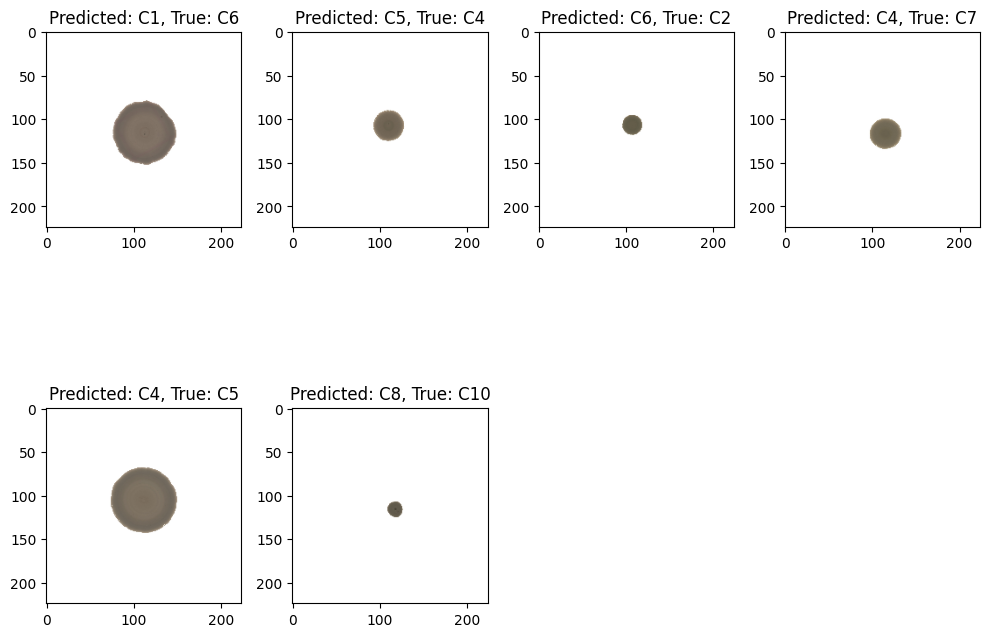

In [146]:
# Call the function to plot the missclassified images in the first dataset (they were missclassified by first vgg in first fold)
N = 4  # columns
fold = 1
plot_missclassified_images(dataset_mismatched_images, fold, N)

## Spider Plot Metrics

In [147]:
metrics_report = classification_report(y_true_flatten, y_pred_flatten)

In [148]:
import plotly.graph_objects as go

In [149]:
# Parse the classification report string into a dictionary
def parse_classification_report(report):
    report_dict = {}
    lines = report.split('\n')
    for line in lines[2:-5]:
        parts = line.split()
        label = parts[0]
        precision = float(parts[1])
        recall = float(parts[2])
        f1_score = float(parts[3])
        support = int(parts[4])
        report_dict[label] = {
            'precision': precision,
            'recall': recall,
            'f1-score': f1_score,
            'support': support
        }
    return report_dict

In [150]:
classification_report = parse_classification_report(metrics_report)

# Extract metric values for each label
labels = list(classification_report.keys())
metrics = ['precision', 'recall', 'f1-score']

# Create a dictionary to store metric values for each label
label_metrics = {label: [] for label in labels}

for metric in metrics:
    for label in labels:
        label_metrics[label].append(classification_report[label][metric])

# Define colors for each line
colors = ['red', 'green', 'blue', 'orange', 'purple', 'pink', 'cyan', 'magenta', 'yellow', 'brown']

# Create a DataFrame from the metric values
df_metricas = pd.DataFrame(label_metrics)

fig = go.Figure()

for i, label in enumerate(labels):
    fig.add_trace(go.Scatterpolar(
        name=label,
        r=df_metricas[label],
        theta=metrics,
        mode='lines',
        fill='none',
        line=dict(color=colors[i]),
    ))

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True)),
    showlegend=True,
    title='Spider Plot of Classification Metrics',
    titlefont={'size': 28, 'family': 'Serif'},
    template='plotly_dark',
    paper_bgcolor='gray',
    width=800,
    height=600,
    font=dict(size=15),
)

fig.show()


## Confusion Matrix

In [151]:
cf_matrix = tf.math.confusion_matrix(
          y_true_flatten,
          y_pred_flatten,
          num_classes=10,
          dtype=float,
          name="Confusion Matrix"
        )

In [152]:
colors_error = ["#94D2BD","#E9D8A6","#EE9B00","#CA6702","#BB3E03","#AE2012","#9B2226","#005F73"]
cmap_error = LinearSegmentedColormap.from_list("", colors_error)

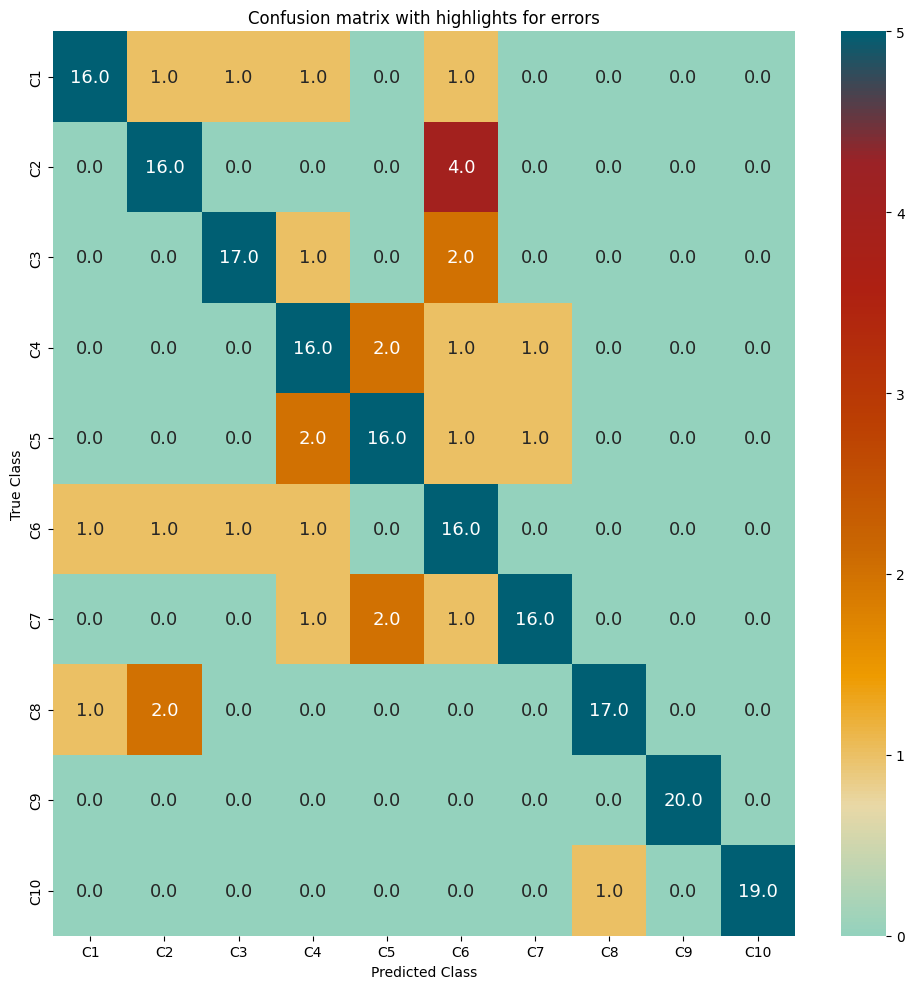

In [153]:
plt.figure(figsize=(10,10))
sn.heatmap(cf_matrix,
           annot=True,
           fmt="",
           annot_kws={"size": 13},
           xticklabels=CLASSES,
           yticklabels=CLASSES,
           cmap=cmap_error,
           vmin=0,
           vmax=5)

plt.title("Confusion matrix with highlights for errors")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")

plt.show()

# XAI METHODS

## LIME

In [154]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=b6634608d62a3d19666118315b74638b605201d81560ae776b935c6ffb55c716
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [155]:
from lime import lime_image

In [156]:
explainer = lime_image.LimeImageExplainer(random_state = RANDOM_SEED)

Use lime explainer in the missclassified images from first fold (using first vgg)

In [158]:
iterator = dataset_mismatched_images[0].as_numpy_iterator()

batch = iterator.next()

images = batch[0]
labels = np.argmax(batch[1], axis=1)

Lime prediction for **one** image

In [159]:
TOP_LABELS = 5
NUM_SAMPLES = 100

use first vgg16 (models[0])

In [161]:
vgg16_fold1 = models[0]

In [162]:
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[0].squeeze(), vgg16_fold1.predict, top_labels=TOP_LABELS, hide_color=0, num_samples=NUM_SAMPLES, random_seed=RANDOM_SEED)

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 62ms/step


In [163]:
from skimage.segmentation import mark_boundaries

Original Image

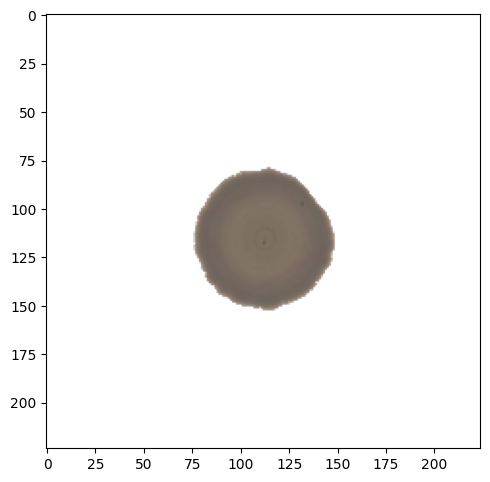

In [164]:
plt.rcParams["figure.figsize"] = [5, 5]
plt.imshow(images[0])

In [165]:
top_class = 0
top_pixels = 10

See the top 5 superpixel for the original image

In [166]:
classes = ["C1","C2","C3","C4","C5","C6","C7","C8","C9","C10"]

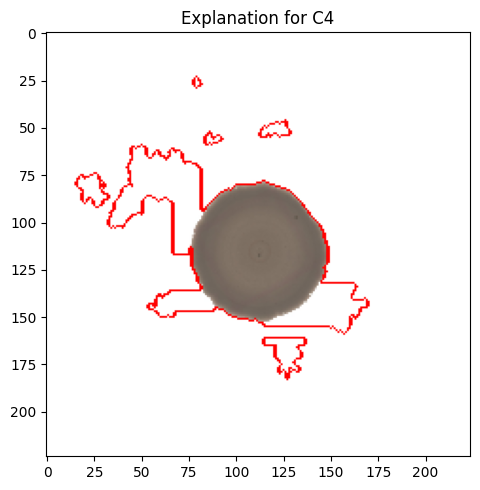

In [167]:
# see the explanation for the top class
temp, mask = explanation.get_image_and_mask(explanation.top_labels[top_class], positive_only=True, num_features=top_pixels, hide_rest=False)
plt.title('Explanation for ' + classes[explanation.top_labels[top_class]])
plt.imshow(mark_boundaries(temp, mask * 255, color=(255,0,0)))

In [168]:
def plot_comparison(main_image, img, mask):
    fig = plt.figure(figsize=(15,5))

    ax = fig.add_subplot(141)
    ax.imshow(main_image, cmap="gray");
    ax.set_title("Original Image")
    ax = fig.add_subplot(142)
    ax.imshow(img);
    ax.set_title("Image")
    ax = fig.add_subplot(143)
    ax.imshow(mask);
    ax.set_title("Mask")
    ax = fig.add_subplot(144)
    ax.imshow(mark_boundaries(img, mask, color=(0,1,0)));
    ax.set_title("Image+Mask Combined");

Another plot from

https://coderzcolumn.com/tutorials/artificial-intelligence/lime-explain-keras-image-classification-network-predictions

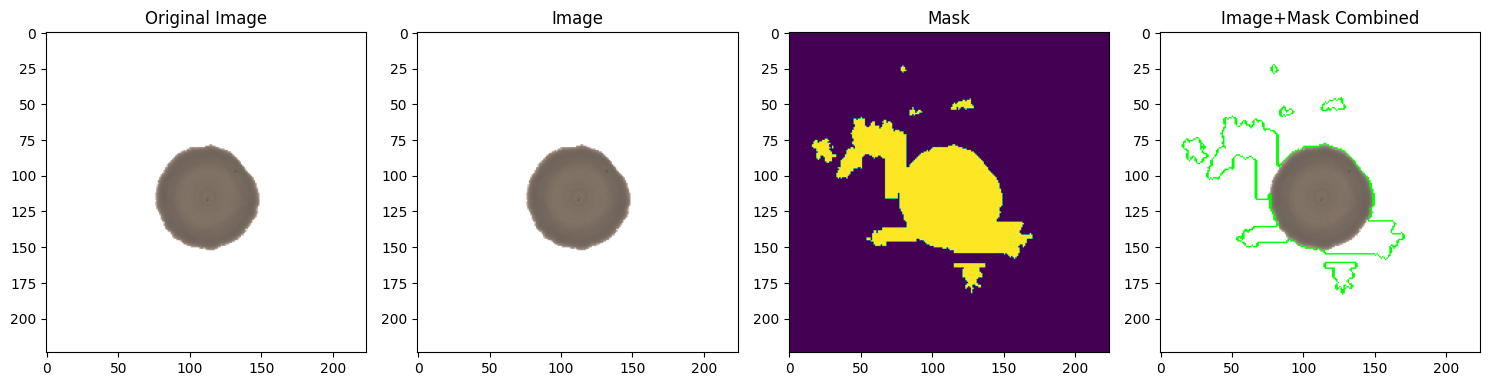

In [169]:
plot_comparison(images[0], temp, mask)

Show more superpixels (they must not be so relevant)

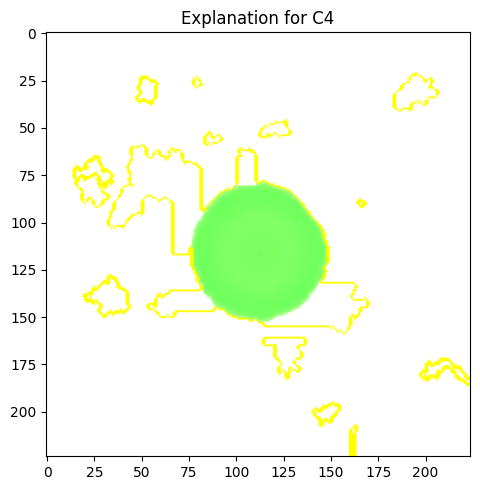

In [170]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=20, hide_rest=False)
plt.title('Explanation for ' + classes[explanation.top_labels[top_class]])
plt.imshow(mark_boundaries(temp, mask))

## SHAP

In [171]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 7.5 MB/s eta 0:00:00


In [172]:
import shap

[masker](https://shap.readthedocs.io/en/latest/generated/shap.maskers.Image.html)

example in [gitHub](https://github.com/shap/shap/blob/master/notebooks/api_examples/plots/image.ipynb)

Use SHAP in first vgg16

In [173]:
# This masks out image regions with blurring or inpainting.
# define a masker that is used to mask out partitions of the input image, this one uses a blurred background
# masker = shap.maskers.Image("inpaint_telea", x_train[0].shape)
masker = shap.maskers.Image("blur(128,128)", INPUT_SHAPE)

In [174]:
# By default the Partition explainer is used for all  partition explainer
explainer = shap.Explainer(vgg16_fold1, masker, output_names = classes)

In [175]:
# 5000 evaluations of the underlying model to estimate the SHAP values
def get_shap_values(images):
  return explainer(images, max_evals=5000, batch_size=50, outputs=shap.Explanation.argsort.flip[:3])

choose the indexes of the images to be explained

In [176]:
shap_values = get_shap_values(images)

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer:  17%|█▋        | 1/6 [00:00<?, ?it/s]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer:  50%|█████     | 3/6 [02:00<01:02, 21.00s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer:  67%|██████▋   | 4/6 [02:42<00:59, 29.70s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer:  83%|████████▎ | 5/6 [03:23<00:33, 33.88s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 6/6 [04:05<00:00, 36.60s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 7it [04:47, 47.89s/it]


### Output classes

In [177]:
# classes that the model predict for the selected images
outputClasses = np.argmax(vgg16_fold1.predict(images), axis=1)

1/1 [==============================] - 1s 1s/step


In [178]:
outputClasses

array([3, 3, 0, 6, 6, 2])

In [179]:
output_labels = [classes[output] for output in outputClasses]

In [180]:
labels

array([3, 3, 0, 6, 6, 2])

In [181]:
true_labels = [classes[label] for label in labels]

In [182]:
true_labels

['C4', 'C4', 'C1', 'C7', 'C7', 'C3']

### Plot Shap Values

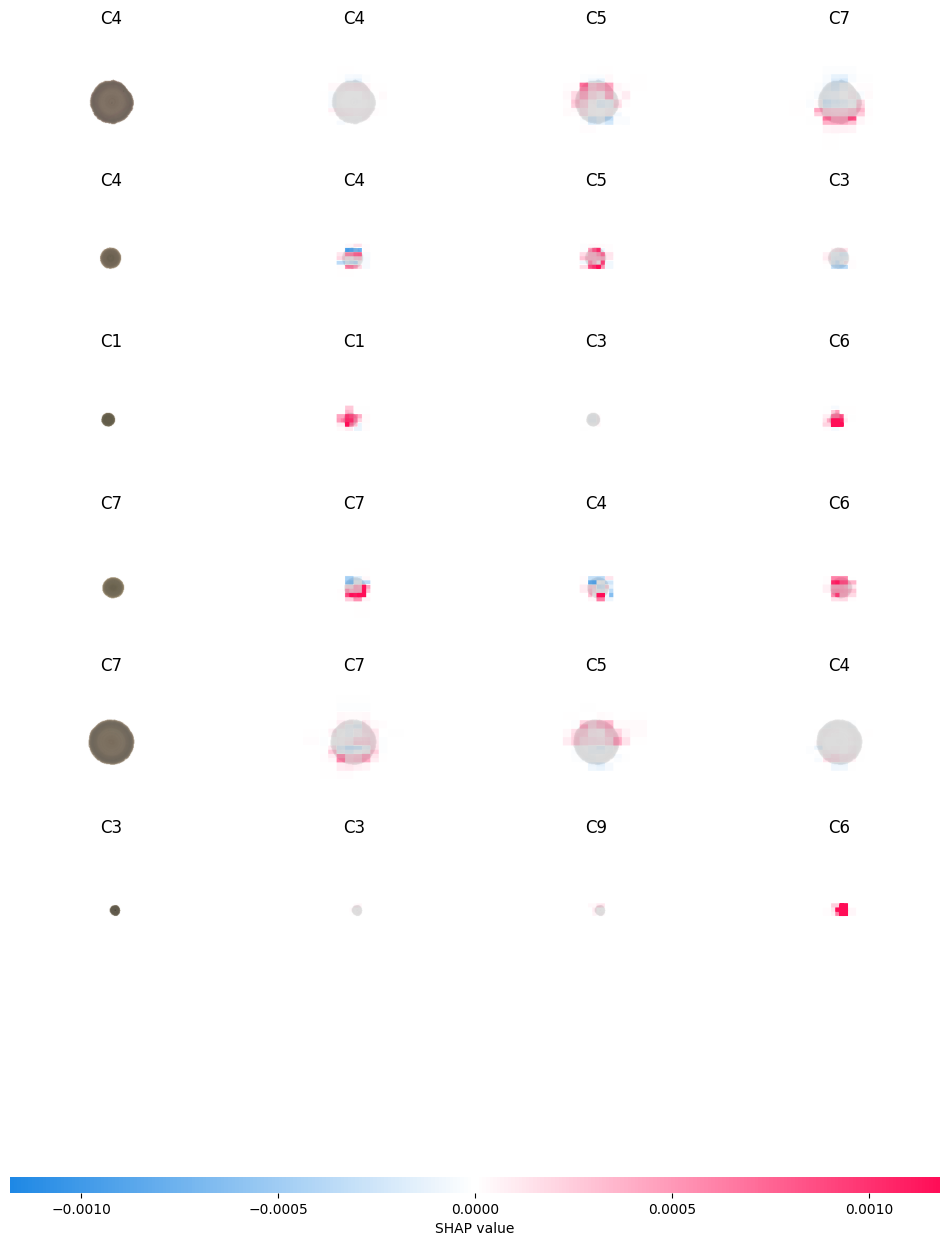

In [183]:
plt.style.use('default')
shap.image_plot(shap_values, true_labels = true_labels)

## GRAD-CAM

Use GRAD-CAM in first vgg16 model ( from first fold)

https://www.kaggle.com/code/siddharthchaini/gradcam-tutorial

In [184]:
pip install tf-keras-vis tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 1.1 MB/s eta 0:00:00


In [185]:
# define the grand cam function
from tf_keras_vis.utils import normalize
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
import cv2

In [186]:
# define the model modifier - change the activation function
def model_modifier(mdl):
    mdl.layers[-1].activation = tf.keras.activations.linear # we change the activation function of last layer to linear

In [187]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

In [188]:
replace2linear = ReplaceToLinear()

In [189]:
from tf_keras_vis.utils.scores import CategoricalScore

In [190]:
score = CategoricalScore(list(outputClasses))

In [191]:
titles = []
for i in range(len(true_labels)):
  titles.append('Pred: ' + output_labels[i] + ' True: ' + true_labels[i])
titles

['Pred: C4 True: C4',
 'Pred: C4 True: C4',
 'Pred: C1 True: C1',
 'Pred: C7 True: C7',
 'Pred: C7 True: C7',
 'Pred: C3 True: C3']

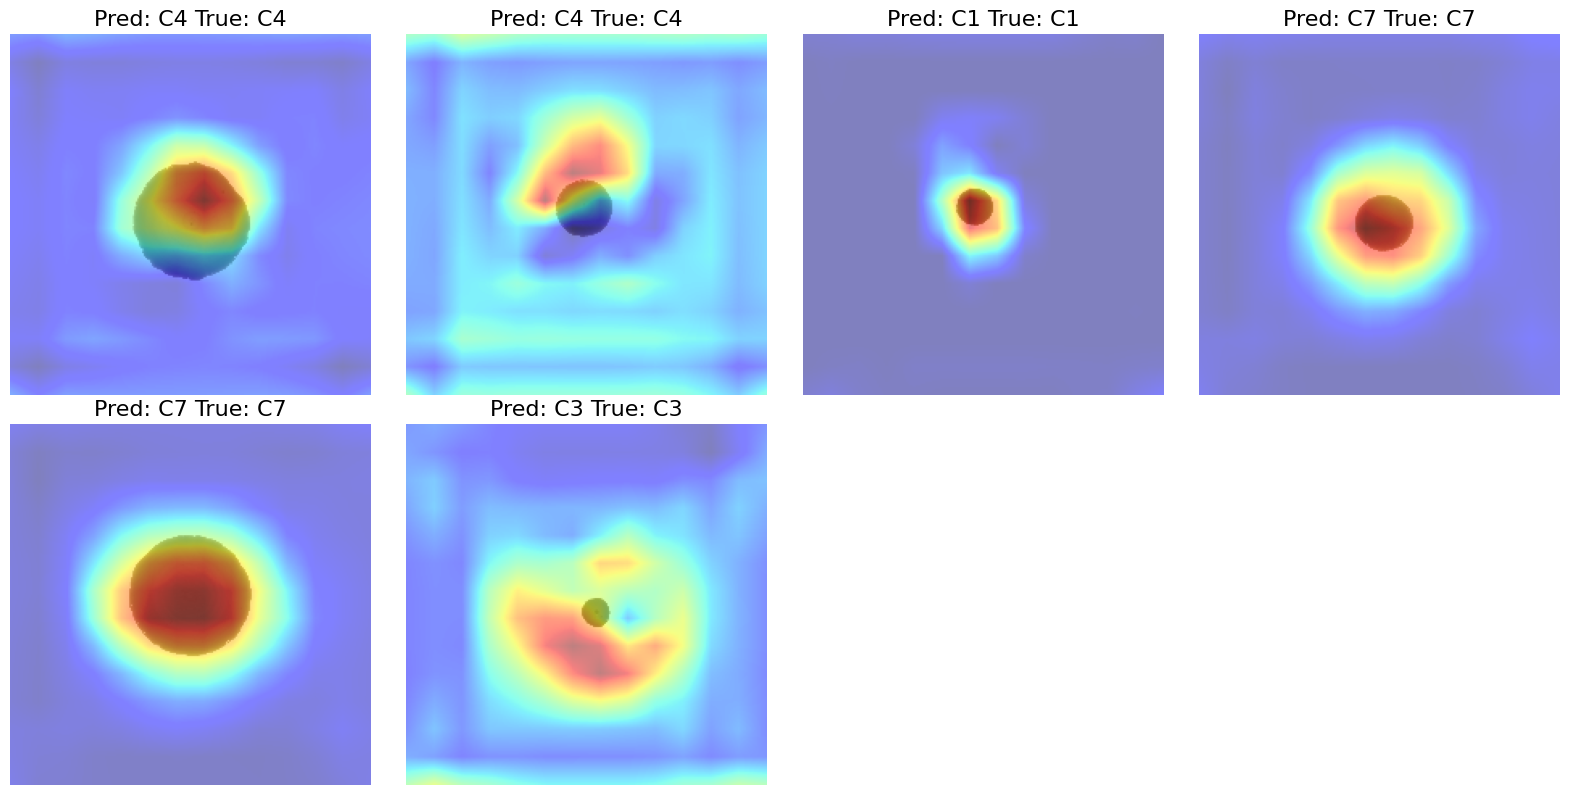

In [192]:
# Create Gradcam object
gradcam = Gradcam(vgg16_fold1,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              images,
              penultimate_layer=-1)

# Define the number of rows and columns
n_columns = 4  # Define the number of columns
n_rows = (images.shape[0] + n_columns - 1) // n_columns  # Calculate the number of rows based on the number of images

# Create subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_columns, figsize=(16, 8))

# Flatten axes for iteration
axes = axes.flatten()

# Iterate over images and titles
for i, (title, image, heatmap) in enumerate(zip(titles, images, cam)):
    ax = axes[i]
    heatmap = np.uint8(cm.jet(heatmap)[..., :3] * 255)
    ax.set_title(title, fontsize=16)
    ax.imshow(image)
    ax.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay heatmap
    ax.axis('off')

# Remove empty subplots
for j in range(len(titles), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


https://github.com/feitgemel/TensorFlowProjects/blob/master/CNN-Visualization/Cnn-Visual-GradCam.py

https://github.com/ramprs/grad-cam/

https://keras.io/examples/vision/grad_cam/